# Tutorial2: PyTorch basics

## Outline

- Datasets
- Models
- Losses
- Optimizers

Official resources:
* [Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

Here no details, mostly visualization, with linear regression.

### Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

In [3]:
x = torch.rand(20, 5)
x
((x.norm(dim=1) - 1).abs() < 1e-10).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Datasets

### A raw dataset

The data are obtained from the model 
$$
x \mapsto y:=Ax + b
$$
with $x\in\mathbb R^{input\_dim}$ and $y\in\mathbb R^{output\_dim}$.

In [5]:
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: A @ x + b

We get a training set by randomly sampling and noisy observations
\begin{align*}
&x_i \sim U([-1, 1])\\
&y_i = A x_i + b + \nu_i
\end{align*}

In [6]:
n_train = 1000
noise_level = 0.04

# Generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# Add some noise
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

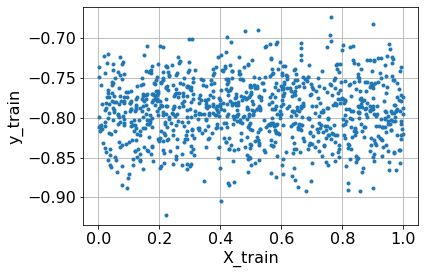

In [10]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

### PyTorch `Dataset`

In [11]:
from utils import VectorialDataset
training_set = VectorialDataset(input_data=X_train, output_data=y_train)

In [12]:
len(training_set)

1000

In [13]:
training_set[10:12]

(tensor([[0.4033],
         [0.4391]]),
 tensor([[-0.7211],
         [-0.7406]]))

Here almost useless, but think about e.g. images.

### PyTorch `DataLoader`

In [14]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

The role of `batch_size`:

In [15]:
for idx, batch in enumerate(train_loader):
    print('Batch n. %2d: input size=%s, output size=%s' % (idx+1, batch[0].shape, batch[1].shape))

Batch n.  1: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  2: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  3: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  4: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  5: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  6: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  7: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  8: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  9: input size=torch.Size([40, 1]), output size=torch.Size([40, 1])


In [16]:
8 * 120

960

The role of `shuffle`:

In [17]:
first_batch = []

for epoch in range(2):
    for idx, batch in enumerate(train_loader):
        if idx == 0:
            first_batch.append(batch)
        
np.c_[X_train[:batch_size], first_batch[0][0].numpy(), first_batch[1][0].numpy()]

array([[0.86308638, 0.26950827, 0.48156217],
       [0.68061245, 0.74153584, 0.90977299],
       [0.64244186, 0.06982955, 0.18676703],
       [0.25656235, 0.5737682 , 0.78777444],
       [0.27827138, 0.39189798, 0.92509937],
       [0.48433658, 0.23385587, 0.42256525],
       [0.58750443, 0.90046966, 0.17118563],
       [0.03687051, 0.11277963, 0.08451173],
       [0.64867428, 0.73666126, 0.3358672 ],
       [0.31411288, 0.91327626, 0.5205617 ],
       [0.40334622, 0.06661855, 0.23996896],
       [0.43910124, 0.22946835, 0.12335587],
       [0.14632331, 0.27942598, 0.57857013],
       [0.15396671, 0.46221042, 0.07629551],
       [0.03036161, 0.25609592, 0.18844005],
       [0.42256525, 0.56942052, 0.40334621],
       [0.20480584, 0.15906392, 0.76988441],
       [0.85774913, 0.67008471, 0.16678913],
       [0.85012887, 0.547171  , 0.49169832],
       [0.00416855, 0.37473175, 0.84561193],
       [0.49537374, 0.6624583 , 0.28496179],
       [0.78834267, 0.58071798, 0.35812473],
       [0.

## Models

We implement a linear model $$x \mapsto model(x):=A x + b$$ 

with $A\in \mathbb{R}^{input\_dim\times output\_dim}$, $b\in\mathbb{R}^{output\_dim}$.

In [18]:
from utils import LinearModel
model = LinearModel(input_dim, output_dim)

### Model inspection

In [19]:
print(model)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


See [pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html) for many other layers.

In [20]:
list(model.parameters())

[Parameter containing:
 tensor([[0.2336]], requires_grad=True),
 Parameter containing:
 tensor([0.6120], requires_grad=True)]

In [21]:
model.linear.weight

Parameter containing:
tensor([[0.2336]], requires_grad=True)

In [22]:
model.linear.bias

Parameter containing:
tensor([0.6120], requires_grad=True)

### The `forward` method

In [23]:
x = torch.randn(5, input_dim)
model.forward(x)

tensor([[0.5000],
        [0.9505],
        [0.4189],
        [0.6124],
        [0.9021]], grad_fn=<AddmmBackward>)

In [24]:
[model.linear.weight @ xx + model.linear.bias for xx in x]

[tensor([0.5000], grad_fn=<AddBackward0>),
 tensor([0.9505], grad_fn=<AddBackward0>),
 tensor([0.4189], grad_fn=<AddBackward0>),
 tensor([0.6124], grad_fn=<AddBackward0>),
 tensor([0.9021], grad_fn=<AddBackward0>)]

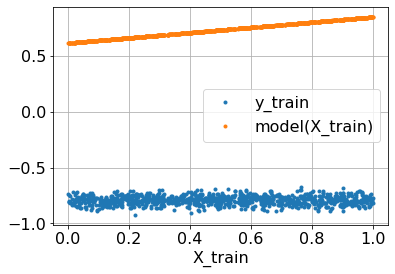

In [25]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)'])    

## Losses

### The MSE loss

The MSE loss is
$$
L(y, y') = \|y-y'\|_2^2
$$

In [26]:
import torch.nn as nn
loss_fun = nn.MSELoss(reduction='mean')

More at [pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [27]:
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)

tensor(2.)

### Giving a score to the model (parameters) given the training set

The loss for one data pair $(x_i, y_i)$ is 
$$
L(model(x_i), y_i)
$$

The cumulative (average) loss on the training set is 
$$
L(X_{train}, y_{train}):=\frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(model(x_i), y_i)
$$

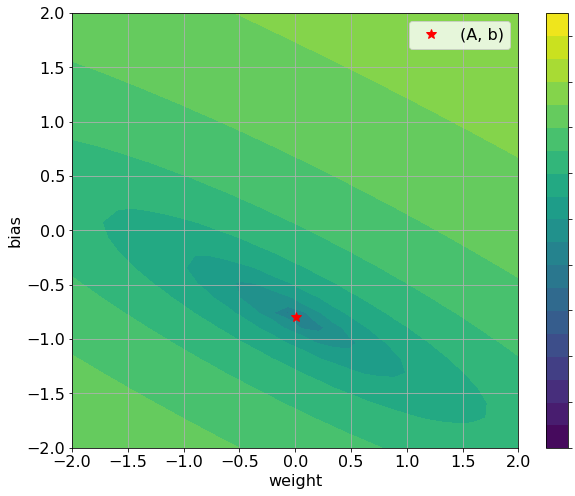

In [28]:
if input_dim == output_dim == 1:

    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(A, b)'])
    
    ax.grid(True)    

## Optimization

Goal: minimize the loss given the data:
$$
\min\limits_{par \in model} L(X_{train}, y_{train})
=\min\limits_{par \in model} \frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(x_i, model(x_i))
$$

In this case $par =\{A, b\}$.

Iterative gradient based optimization:
\begin{align*}
par^{(0)} &= par_0\\
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X_{train}, y_{train})
\end{align*}    
with learning rate $\eta^{(k)}$.

### Gradients

The model is 
$$
model(x) = A x + b
$$

With $input\_dim = output\_dim = 1$ we have $A:=a\in\mathbb{R},\ b\in\mathbb{R}$. 

For a data pair $(x, y)$ the loss is
\begin{align*}
L(x, y) 
&= \|model(x)-y\|_2^2\\ 
&= (model(x)-y)^2\\
&= (a x + b - y)^2\\
&= a^2 x^2 + 2 a b x - 2 a xy + b^2 -2 b y + y^2.
\end{align*}

We can compute
\begin{align*}
\nabla_a L(x, y) 
&= 2 a x^2 + 2 b x - 2 xy
=2 x (a x + b - y)\\
\nabla_b L(x, y)
&= 2 a x + 2 b - 2 y
= 2 (ax + b - y).
\end{align*}


In [23]:
x = torch.randn(1, input_dim)
y =  torch.randn(1, output_dim)

model.zero_grad()
loss = loss_fun(model.forward(x),  y)
loss.backward()

In [24]:
if input_dim == output_dim == 1:
    print(model.linear.weight.grad)
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))
    
    print(model.linear.bias.grad)
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[2.7173]])
tensor([[2.7173]], grad_fn=<MulBackward0>)
tensor([-1.6603])
tensor([[-1.6603]], grad_fn=<MulBackward0>)


### Handmade optimization

In [25]:
if input_dim == output_dim == 1:

    num_iter = 200
    lr = 0.5 # 0.01

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

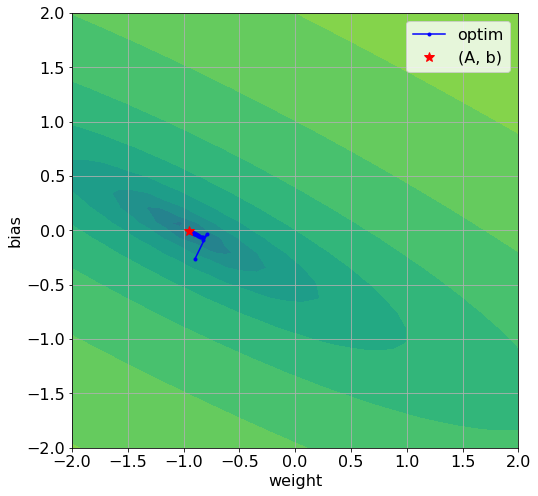

In [26]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    ax.legend(['optim', '(A, b)'])

### Stochastic GD

* Avoid loading the full training set
* Avoid evaluating the model on the full training set

At every step, compute the loss on a batch of data $(X^{(k)}, y^{(k)})\sim (X_{train}, y_{train})$: 

\begin{align*}
L(X^{(k)}, y^{(k)}) := \sum_{(x, y) \in (X^{(k)}, y^{(k)})} L(x, model(x)).
\end{align*}    

and then update with this approximated gradient:
\begin{align*}
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X^{(k)}, y^{(k)}). 
\end{align*}    

### PyTorch `optim`

In [27]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

More at [pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html).

In [28]:
n_epochs = 100

In [29]:
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        loss = loss_fun(model.forward(batch[0]),  batch[1])
        loss.backward()
        optimizer.step()

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())
        
        print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
        
model.eval()

[Epoch    1/ 100] [Batch    1/   9] Loss:  6.43e-01
[Epoch    1/ 100] [Batch    2/   9] Loss:  4.28e-01
[Epoch    1/ 100] [Batch    3/   9] Loss:  2.63e-01
[Epoch    1/ 100] [Batch    4/   9] Loss:  1.34e-01
[Epoch    1/ 100] [Batch    5/   9] Loss:  4.86e-02
[Epoch    1/ 100] [Batch    6/   9] Loss:  1.49e-02
[Epoch    1/ 100] [Batch    7/   9] Loss:  8.63e-03
[Epoch    1/ 100] [Batch    8/   9] Loss:  2.77e-02
[Epoch    1/ 100] [Batch    9/   9] Loss:  6.80e-02
[Epoch    2/ 100] [Batch    1/   9] Loss:  7.90e-02
[Epoch    2/ 100] [Batch    2/   9] Loss:  1.02e-01
[Epoch    2/ 100] [Batch    3/   9] Loss:  1.02e-01
[Epoch    2/ 100] [Batch    4/   9] Loss:  1.01e-01
[Epoch    2/ 100] [Batch    5/   9] Loss:  8.37e-02
[Epoch    2/ 100] [Batch    6/   9] Loss:  6.60e-02
[Epoch    2/ 100] [Batch    7/   9] Loss:  4.42e-02
[Epoch    2/ 100] [Batch    8/   9] Loss:  3.47e-02
[Epoch    2/ 100] [Batch    9/   9] Loss:  1.73e-02
[Epoch    3/ 100] [Batch    1/   9] Loss:  6.00e-03
[Epoch    3/

[Epoch   31/ 100] [Batch    6/   9] Loss:  1.44e-03
[Epoch   31/ 100] [Batch    7/   9] Loss:  1.67e-03
[Epoch   31/ 100] [Batch    8/   9] Loss:  1.29e-03
[Epoch   31/ 100] [Batch    9/   9] Loss:  1.57e-03
[Epoch   32/ 100] [Batch    1/   9] Loss:  1.88e-03
[Epoch   32/ 100] [Batch    2/   9] Loss:  1.71e-03
[Epoch   32/ 100] [Batch    3/   9] Loss:  1.70e-03
[Epoch   32/ 100] [Batch    4/   9] Loss:  1.32e-03
[Epoch   32/ 100] [Batch    5/   9] Loss:  1.74e-03
[Epoch   32/ 100] [Batch    6/   9] Loss:  1.44e-03
[Epoch   32/ 100] [Batch    7/   9] Loss:  1.72e-03
[Epoch   32/ 100] [Batch    8/   9] Loss:  1.62e-03
[Epoch   32/ 100] [Batch    9/   9] Loss:  1.17e-03
[Epoch   33/ 100] [Batch    1/   9] Loss:  1.86e-03
[Epoch   33/ 100] [Batch    2/   9] Loss:  1.51e-03
[Epoch   33/ 100] [Batch    3/   9] Loss:  1.34e-03
[Epoch   33/ 100] [Batch    4/   9] Loss:  2.01e-03
[Epoch   33/ 100] [Batch    5/   9] Loss:  1.52e-03
[Epoch   33/ 100] [Batch    6/   9] Loss:  1.25e-03
[Epoch   33/

[Epoch   60/ 100] [Batch    4/   9] Loss:  1.65e-03
[Epoch   60/ 100] [Batch    5/   9] Loss:  2.04e-03
[Epoch   60/ 100] [Batch    6/   9] Loss:  1.33e-03
[Epoch   60/ 100] [Batch    7/   9] Loss:  1.19e-03
[Epoch   60/ 100] [Batch    8/   9] Loss:  1.79e-03
[Epoch   60/ 100] [Batch    9/   9] Loss:  1.65e-03
[Epoch   61/ 100] [Batch    1/   9] Loss:  1.28e-03
[Epoch   61/ 100] [Batch    2/   9] Loss:  1.40e-03
[Epoch   61/ 100] [Batch    3/   9] Loss:  1.62e-03
[Epoch   61/ 100] [Batch    4/   9] Loss:  1.67e-03
[Epoch   61/ 100] [Batch    5/   9] Loss:  1.98e-03
[Epoch   61/ 100] [Batch    6/   9] Loss:  1.62e-03
[Epoch   61/ 100] [Batch    7/   9] Loss:  1.29e-03
[Epoch   61/ 100] [Batch    8/   9] Loss:  2.12e-03
[Epoch   61/ 100] [Batch    9/   9] Loss:  2.07e-03
[Epoch   62/ 100] [Batch    1/   9] Loss:  1.60e-03
[Epoch   62/ 100] [Batch    2/   9] Loss:  1.38e-03
[Epoch   62/ 100] [Batch    3/   9] Loss:  1.55e-03
[Epoch   62/ 100] [Batch    4/   9] Loss:  1.89e-03
[Epoch   62/

[Epoch   91/ 100] [Batch    1/   9] Loss:  1.51e-03
[Epoch   91/ 100] [Batch    2/   9] Loss:  1.94e-03
[Epoch   91/ 100] [Batch    3/   9] Loss:  1.51e-03
[Epoch   91/ 100] [Batch    4/   9] Loss:  1.72e-03
[Epoch   91/ 100] [Batch    5/   9] Loss:  1.38e-03
[Epoch   91/ 100] [Batch    6/   9] Loss:  1.88e-03
[Epoch   91/ 100] [Batch    7/   9] Loss:  1.68e-03
[Epoch   91/ 100] [Batch    8/   9] Loss:  1.52e-03
[Epoch   91/ 100] [Batch    9/   9] Loss:  1.51e-03
[Epoch   92/ 100] [Batch    1/   9] Loss:  1.58e-03
[Epoch   92/ 100] [Batch    2/   9] Loss:  1.54e-03
[Epoch   92/ 100] [Batch    3/   9] Loss:  1.85e-03
[Epoch   92/ 100] [Batch    4/   9] Loss:  1.70e-03
[Epoch   92/ 100] [Batch    5/   9] Loss:  1.52e-03
[Epoch   92/ 100] [Batch    6/   9] Loss:  1.25e-03
[Epoch   92/ 100] [Batch    7/   9] Loss:  2.05e-03
[Epoch   92/ 100] [Batch    8/   9] Loss:  1.76e-03
[Epoch   92/ 100] [Batch    9/   9] Loss:  1.56e-03
[Epoch   93/ 100] [Batch    1/   9] Loss:  1.59e-03
[Epoch   93/

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [30]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())    

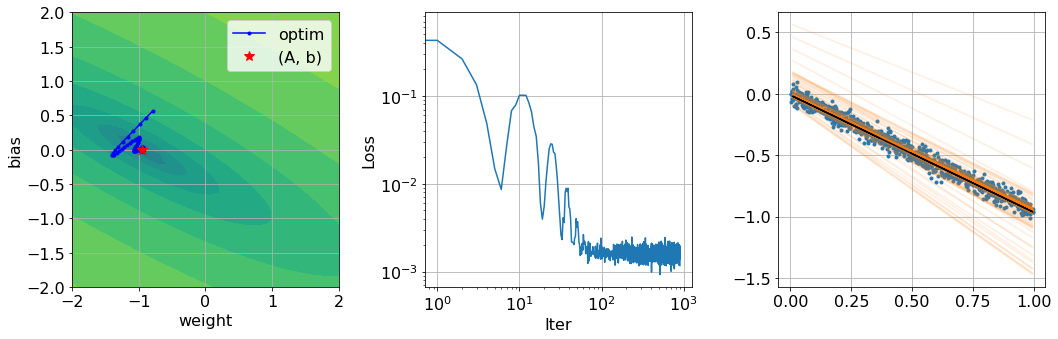

In [31]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()
    
    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.legend(['optim', '(A, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)   

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)